This is based on https://cookbook.openai.com/examples/parse_pdf_docs_for_rag

In [6]:
# Imports
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
import io
import os
import concurrent.futures
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval
from PyPDF2 import PdfReader
from convert_pptx import convert_all_pptx_to_pdf
# testing

## File Processing

In [7]:
def convert_doc_to_images(path, chunk_size=2):
    
    reader = PdfReader(path)
    total_pages = len(reader.pages)

    all_images = []
    for start_page in range(1, total_pages + 1, chunk_size):
        end_page = min(start_page + chunk_size - 1, total_pages)
        images = convert_from_path(
            path,
            first_page=start_page,
            last_page=end_page,
            dpi = 50
        )
        all_images.extend(images)

    return all_images
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    return text

In [22]:
pages_description = [
    {'Page': 1, 'description': 'Introduction to the document and overview of contents.', 'Fname': 'doc1.pdf'},
    {'Page': 2, 'description': 'Detailed analysis of the first topic covered in the document.', 'Fname': 'doc1.pdf'},
    {'Page': 3, 'description': 'Continuation of the analysis with additional data and graphs.', 'Fname': 'doc1.pdf'},
    {'Page': 4, 'description': 'Summary of findings and conclusions drawn from the analysis.', 'Fname': 'doc1.pdf'},
    {'Page': 5, 'description': 'Appendix with supplementary information and references.', 'Fname': 'doc1.pdf'},
    {'Page': 1, 'description': 'Executive summary and key points of the report.', 'Fname': 'doc2.pdf'},
    {'Page': 2, 'description': 'In-depth discussion on the methodology used in the study.', 'Fname': 'doc2.pdf'},
    {'Page': 3, 'description': 'Case studies and examples illustrating the main concepts.', 'Fname': 'doc2.pdf'},
    {'Page': 4, 'description': 'Final thoughts and recommendations for future research.', 'Fname': 'doc2.pdf'},
    {'Page': 1, 'description': 'Overview of the project scope and objectives.', 'Fname': 'doc3.pdf'},
    {'Page': 2, 'description': 'Technical specifications and requirements.', 'Fname': 'doc3.pdf'},
    {'Page': 3, 'description': 'Implementation plan and timeline.', 'Fname': 'doc3.pdf'},
    {'Page': 4, 'description': 'Risk assessment and mitigation strategies.', 'Fname': 'doc3.pdf'},
    {'Page': 5, 'description': 'Conclusion and next steps.', 'Fname': 'doc3.pdf'}
]


In [24]:
for page in pages_description:
    page['embedding'] = f"It worked! Page{page['Page']}"
pages_description

[{'Page': 1,
  'description': 'Introduction to the document and overview of contents.',
  'Fname': 'doc1.pdf',
  'embedding': 'It worked! Page1'},
 {'Page': 2,
  'description': 'Detailed analysis of the first topic covered in the document.',
  'Fname': 'doc1.pdf',
  'embedding': 'It worked! Page2'},
 {'Page': 3,
  'description': 'Continuation of the analysis with additional data and graphs.',
  'Fname': 'doc1.pdf',
  'embedding': 'It worked! Page3'},
 {'Page': 4,
  'description': 'Summary of findings and conclusions drawn from the analysis.',
  'Fname': 'doc1.pdf',
  'embedding': 'It worked! Page4'},
 {'Page': 5,
  'description': 'Appendix with supplementary information and references.',
  'Fname': 'doc1.pdf',
  'embedding': 'It worked! Page5'},
 {'Page': 1,
  'description': 'Executive summary and key points of the report.',
  'Fname': 'doc2.pdf',
  'embedding': 'It worked! Page1'},
 {'Page': 2,
  'description': 'In-depth discussion on the methodology used in the study.',
  'Fname': 'd

## Test

In [10]:
fpath = '/mnt/data/gartner-research-rag-bot'

convert_all_pptx_to_pdf(fpath)

files = [os.path.join(fpath, f) for f in os.listdir(fpath) if (os.path.isfile(os.path.join(fpath, f)) & (f.split(".")[-1] == "pdf"))]

images = convert_from_path(files[0])

text = extract_text_from_doc(files[0])

✅ Converted: 2025CIO Agenda Top Priorities and Technology Plans for Healthcare Payers - 821358 - 2024.pptx → 2025CIO Agenda Top Priorities and Technology Plans for Healthcare Payers - 821358 - 2024.pdf
✅ Converted: 2025_CIO_Agenda_Top_Priorities_and_Technology_Plans_for_Banking_819801.pptx → 2025_CIO_Agenda_Top_Priorities_and_Technology_Plans_for_Banking_819801.pdf
✅ Converted: GenAI Use Cases in Sourcing and Procurement - ppt - 2024.pptx → GenAI Use Cases in Sourcing and Procurement - ppt - 2024.pdf
✅ Converted: Implement a Risk-Based Approach to Vulnerability Management - ppt - 2018.pptx → Implement a Risk-Based Approach to Vulnerability Management - ppt - 2018.pdf
✅ Converted: Financial Services Business Unit Executives - ppt - 2025.pptx → Financial Services Business Unit Executives - ppt - 2025.pdf
📄 PDF already exists for 4 Ways to Boost Third-Party Cybersecurity Risk Management Effectiveness​.pptx. Deleting the PPTX or DOCX file.
✅ Converted: SAM Initiatives and Stakeholder Busin

In [11]:
text

'IT Key Metrics Data 2025: Industry Measures —\nInsurance Analysis\n\n5 December 2024 - ID G00822073 - 10 min read\n\nBy:\xa0Eric Stegman, Jamie Guevara, Shaivya Kaushal, Aditi Sharma\nInitiatives:CIO Digital Leadership; Technology Finance, Risk and Value Management\n\nGartner collects IT Spending and Stafﬁng data from the IT Budget\n\nTool and other sources on a year round basis. This analysis\nprovides insight into metrics for the Insurance Industry from that\n\ndataset. CIOs and IT Leaders should measure and benchmark\n\ntheir organization’s IT metrics using the IT Budget Tool. These\nbenchmarks can be part of a program to improve cost\n\nmanagement through transparency and regular calibration as a\n\nbest practice.\n\nGartner, Inc. | G00822073\n\nPage 1 of 26\n\nThis research note is restricted to the personal use of wesley.palmer@wwt.com.\n\n\x0cOverview\n\nFigure 1: Executive Summary for Insurance\n\nKey Findings\n\n■\n\n■\n\n■\n\n■\n\nAll of the metrics published in this report 

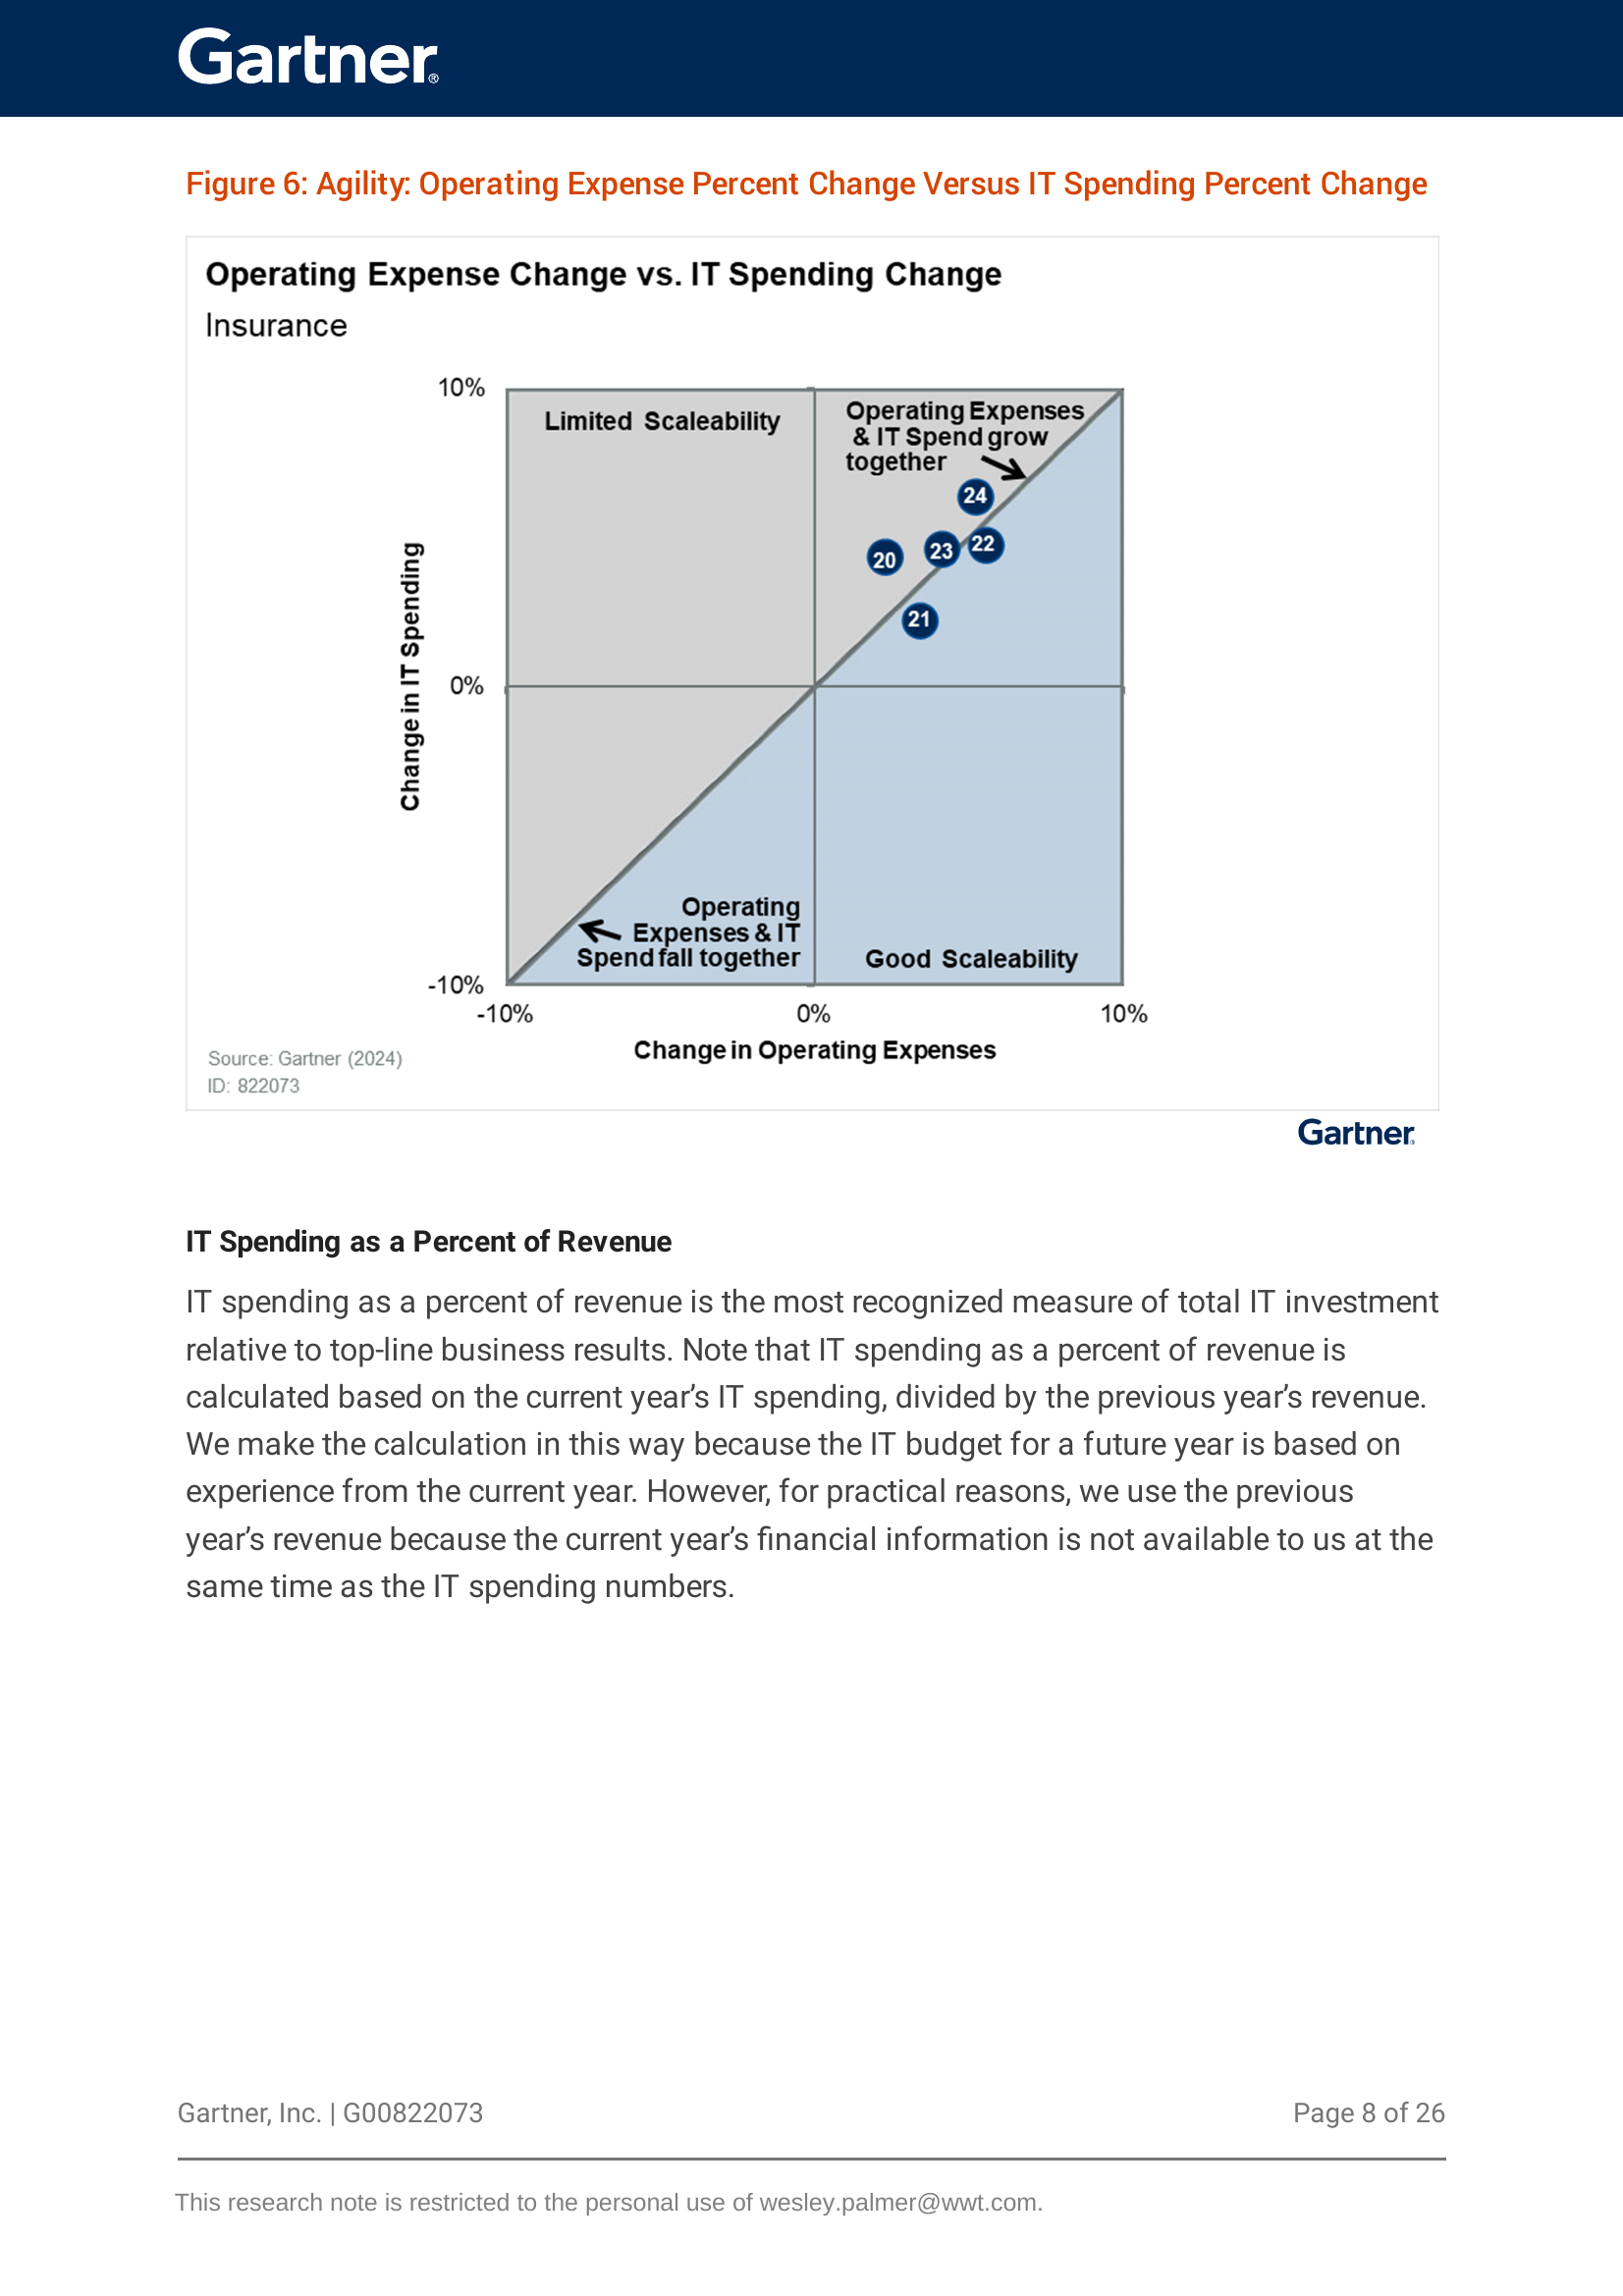

In [13]:
# Show first page
display(images[7])

## Testing Image analysis with OpenAI

In [14]:
# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key = api_key)

In [15]:
# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    png_buffer = io.BytesIO()
    img.save(png_buffer, format="PNG")
    png_buffer.seek(0)

    base64_png = base64.b64encode(png_buffer.read()).decode('utf-8')

    data_uri = f"data:image/png;base64,{base64_png}"
    return data_uri

In [16]:
system_prompt = '''
You will be provided with an image of a PDF page or a slide. Your goal is to deliver a detailed and engaging presentation about the content you see, using clear and accessible language suitable for a 101-level audience.

If there is an identifiable title, start by stating the title to provide context for your audience.

Describe visual elements in detail:

- **Diagrams**: Explain each component and how they interact. For example, "The process begins with X, which then leads to Y and results in Z."
  
- **Tables**: Break down the information logically. For instance, "Product A costs X dollars, while Product B is priced at Y dollars."

Focus on the content itself rather than the format:

- **DO NOT** include terms referring to the content format.
  
- **DO NOT** mention the content type. Instead, directly discuss the information presented.

Keep your explanation comprehensive yet concise:

- Be exhaustive in describing the content, as your audience cannot see the image.
  
- Exclude irrelevant details such as page numbers or the position of elements on the image.

Use clear and accessible language:

- Explain technical terms or concepts in simple language appropriate for a 101-level audience.

Engage with the content:

- Interpret and analyze the information where appropriate, offering insights to help the audience understand its significance.

------

If there is an identifiable title, present the output in the following format:

{TITLE}

{Content description}

If there is no clear title, simply provide the content description.
'''

def analyze_image(data_uri):
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{data_uri}"
                    }
                    }
                ]
                },
        ],
        #max_tokens=500,
        #temperature=0,
        #top_p=0.1
    )
    return response.choices[0].message.content

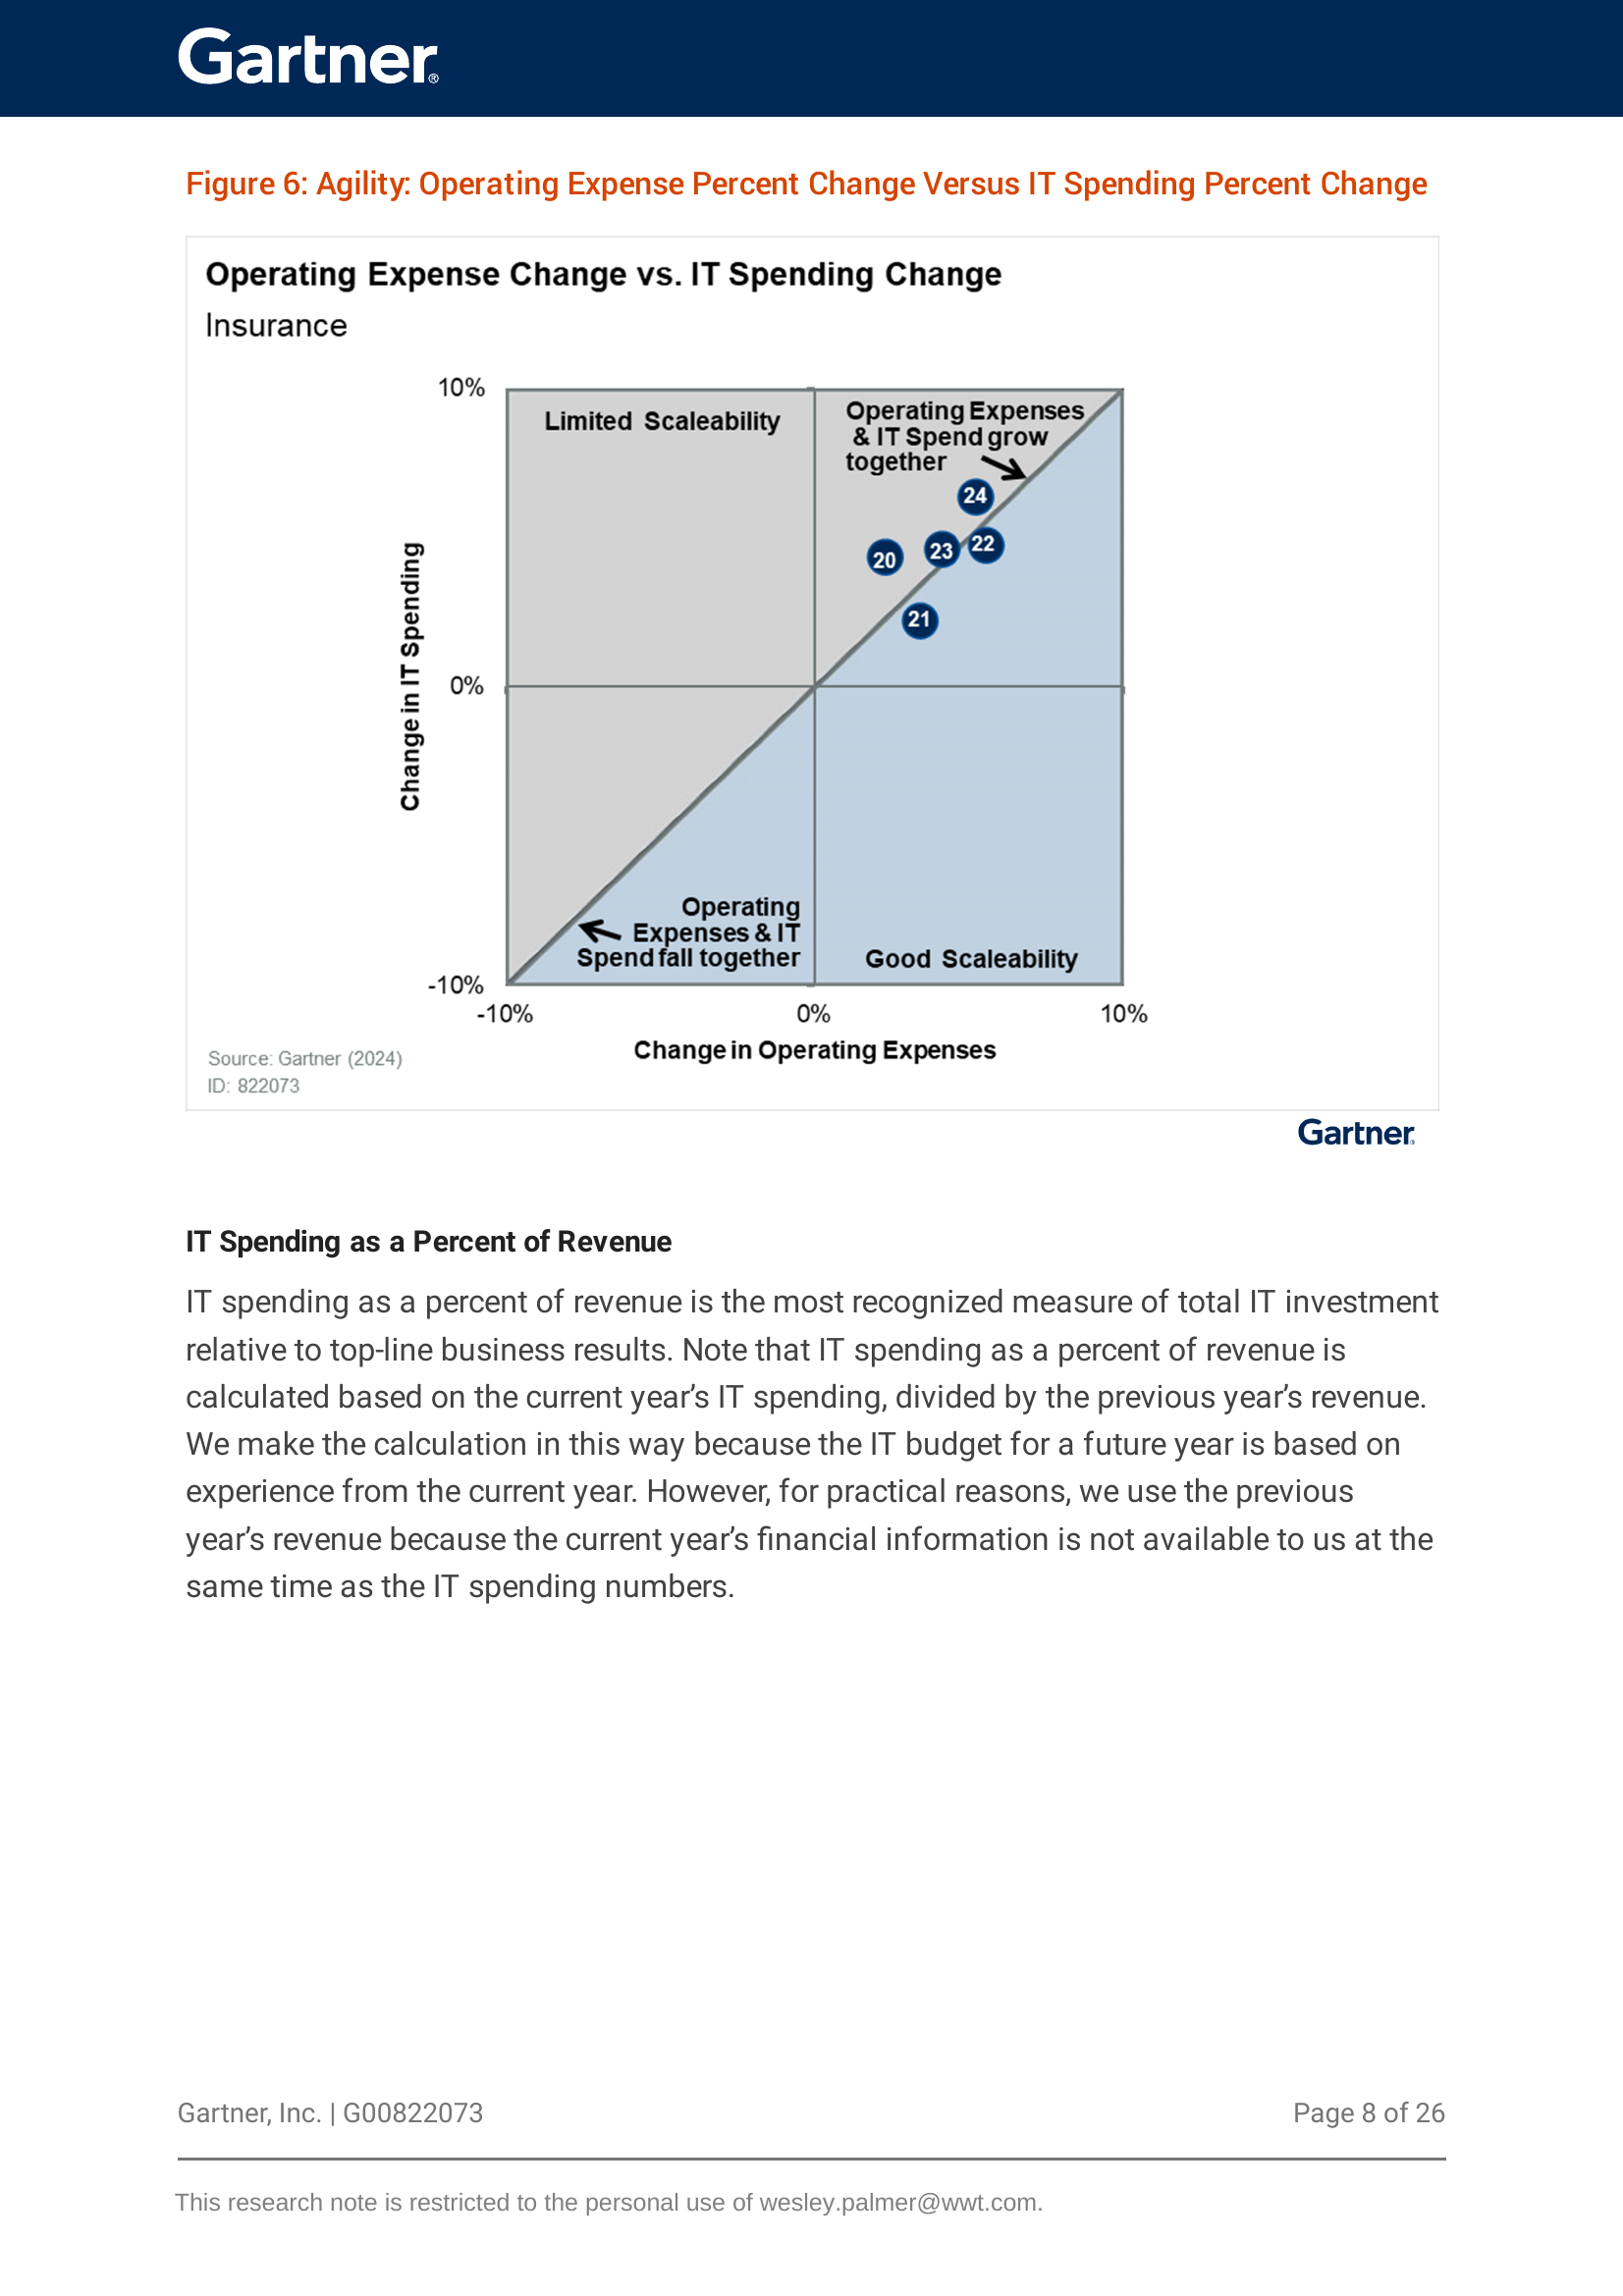

In [17]:
img = images[7]
display(img)
data_uri = get_img_uri(img)

In [18]:
res = analyze_image(data_uri)
print(res)

Figure 6: Agility: Operating Expense Percent Change Versus IT Spending Percent Change

This figure compares percent changes in operating expenses (horizontal axis) with percent changes in IT spending 
(vertical axis) to show how IT investment moves relative to overall operating costs. It is presented for the 
insurance industry and contains a small cluster of labeled points (20–24) that represent individual entities or 
observations.

What the axes show
- X axis (horizontal): Change in operating expenses, from −10% on the left to +10% on the right.
- Y axis (vertical): Change in IT spending, from −10% at the bottom to +10% at the top.
- The diagonal line from bottom-left to top-right separates regions where IT and operating expenses move together 
from regions where they move in opposite directions.

How the chart is divided and what each zone means
- Top-right (both IT spending and operating expenses increase): Labeled “Operating Expenses & IT Spend grow 
together.” When points fall here it means organizations are increasing IT spending at roughly the same time their 
operating costs rise. This can indicate cost coupling — IT budgets grow as the business grows or as costs increase.
- Bottom-left (both IT spending and operating expenses decrease): Labeled “Operating Expenses & IT Spend fall 
together.” Here IT and operating costs decline together, which can reflect cost-cutting across the organization.
- Bottom-right (operating expenses increase, IT spending decreases): Labeled “Good Scaleability.” This is the 
desirable scenario for scalability: the business can expand (higher operating expenses) while IT spending falls or 
grows more slowly, implying greater IT efficiency or technology-enabled cost savings.
- Top-left (operating expenses decrease, IT spending increases): Labeled “Limited Scaleability.” This is a warning 
sign: IT spending rises while overall operating expenses fall, suggesting the IT investment is not delivering 
proportional business growth or efficiency.

What the plotted points indicate
- The numbered points 20, 21, 22, 23, 24 are clustered in the upper-right quadrant near the diagonal. This 
indicates that, for these observations in the insurance sector, both operating expenses and IT spending have 
increased together. That pattern can reflect aligned investment (IT spending increases to support expanded 
operations) but may also indicate limited improvement in cost-efficiency or scalability because costs are rising in
tandem.

Supporting text summary (IT spending as percent of revenue)
- IT spending as a percent of revenue is a common way to measure how much of a company’s top-line is devoted to IT.
- The calculation shown uses the current year’s IT spending divided by the previous year’s revenue. The rationale 
is practical: IT budgets for a future year are informed by current-year IT spending, but current-year revenue 
figures are often not yet finalized when IT spending data are compiled. Using last year’s revenue provides a 
consistent, available denominator.
- This metric is useful for benchmarking IT investment intensity across organizations but should be interpreted 
with the timing caveat above.

Key takeaway
- The chart helps evaluate organizational agility and scaling: ideally you want scenarios where business grows 
without a proportional rise in IT spending (bottom-right). The insurance observations on this chart mostly show 
concurrent growth in IT and operating expenses (upper-right), suggesting increased spending across the board rather
than clear IT-driven efficiency gains.

In [21]:
res

'Figure 6: Agility: Operating Expense Percent Change Versus IT Spending Percent Change\n\nThis figure compares percent changes in operating expenses (horizontal axis) with percent changes in IT spending (vertical axis) to show how IT investment moves relative to overall operating costs. It is presented for the insurance industry and contains a small cluster of labeled points (20–24) that represent individual entities or observations.\n\nWhat the axes show\n- X axis (horizontal): Change in operating expenses, from −10% on the left to +10% on the right.\n- Y axis (vertical): Change in IT spending, from −10% at the bottom to +10% at the top.\n- The diagonal line from bottom-left to top-right separates regions where IT and operating expenses move together from regions where they move in opposite directions.\n\nHow the chart is divided and what each zone means\n- Top-right (both IT spending and operating expenses increase): Labeled “Operating Expenses & IT Spend grow together.” When points 

## Doing it on all files in the dataset

In [12]:
dataset = '/domino/datasets/local/Gartner_Article_Chat'
files = [os.path.join(dataset, f) for f in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, f))]

def analyze_doc_image(img):
    img_uri = get_img_uri(img)
    data = analyze_image(img_uri)
    return data

In [13]:
docs = []

for file in files:
    doc_name = file.split('/')[-1]
    
    doc = {'filename':doc_name}

    text = extract_text_from_doc(file)
    doc['text'] = text
    
    images = convert_doc_to_images(file)

    pages_description = []

    print(f'Analyzing pages for doc {doc_name}')

    # Concurrent execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        
        futures = [
            executor.submit(analyze_doc_image, img)
            for img in images
        ]
        
        with tqdm(total=len(images)-1) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        
        for f in futures:
            res = f.result()
            pages_description.append(res)
        
    doc['pages_description'] = pages_description
    docs.append(doc)

Analyzing pages for doc Banking and Investment Services Business Priority Tracker - 812459 - 2025.pdf

8it [00:31,  3.88s/it]                       


Analyzing pages for doc 2024_CIOs_Reference_Guide_to_Operating-Model_Design_795195_ndx.pdf

 81%|████████  | 38/47 [00:57<00:05,  1.55it/s]

: 

: 